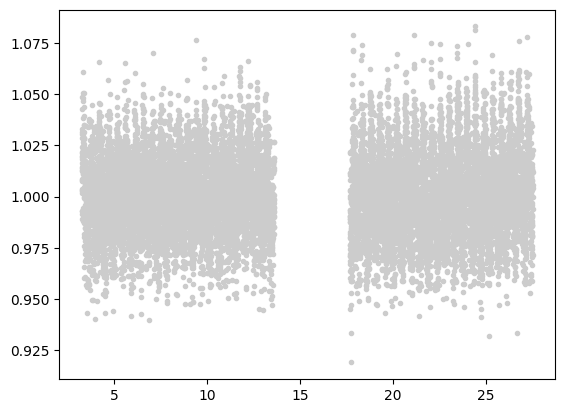

In [168]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

tic = 46157102
data = pickle.load(open('/Users/lgarcia/papers/nuance/workflows/tess_injection_recovery/data/46157102/original.fluxes', 'rb'))

from astropy.stats import LombScargle

from nuance.utils import periodic_transit

plt.plot(data['time'], data['flux'], ".", c="0.8")

0.46946586240018867


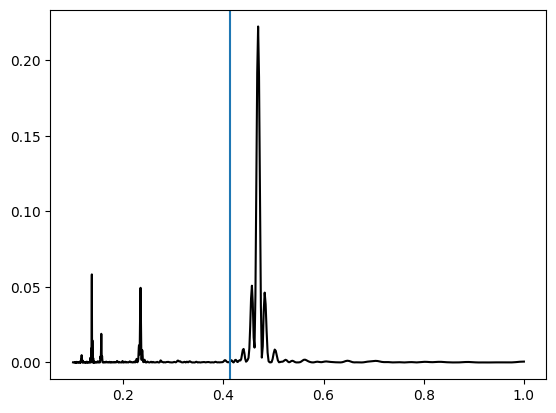

In [169]:
def rotation_period(time, flux):
    """rotation period based on LS periodogram"""

    ls = LombScargle(time, flux)
    frequency, power = ls.autopower(minimum_frequency=1 / 1, maximum_frequency=1 / 0.1)
    period = 1 / frequency[np.argmax(power)]
    plt.plot(1 / frequency, power, "k")
    return period

period = rotation_period(data["time"], data["flux"])
print(period)
plt.axvline(0.41282)

In [170]:
from nuance import Nuance

nu = Nuance(data['time'], data['flux'], data['error'])

In [171]:
from nuance.kernels import rotation

build_gp, init = rotation(period, np.median(data["error"]))
optimize, mu, nll = nu.gp_optimization(build_gp)
params = optimize(
    init, ["log_sigma", "log_short_scale", "log_short_sigma", "log_long_sigma"]
)
params = optimize(params)

ScipyMinimizeInfo(fun_val=Array(-38354.02179245, dtype=float64, weak_type=True), success=False, status=2, iter_num=31, hess_inv=Array([[ 1.04601496e+08, -4.27091106e+02,  8.79574606e+02,
        -1.06374675e+07],
       [-4.27091106e+02,  6.51498207e-03, -2.93933705e-03,
         4.34332008e+01],
       [ 8.79574606e+02, -2.93933705e-03,  7.48588980e-03,
        -8.94485617e+01],
       [-1.06374675e+07,  4.34332008e+01, -8.94485617e+01,
         1.08178019e+06]], dtype=float64), num_fun_eval=Array(56, dtype=int32), num_jac_eval=Array(44, dtype=int32), num_hess_eval=Array(0, dtype=int32))
ScipyMinimizeInfo(fun_val=Array(-38461.6520716, dtype=float64, weak_type=True), success=False, status=2, iter_num=31, hess_inv=Array([[ 1.47084830e+00, -2.73276512e+00,  1.93917435e+00,
         1.00542182e-03,  2.06836272e-31,  8.92078925e-05,
         4.05746594e-03, -5.66876947e-04,  3.35394008e-01],
       [-2.73276512e+00,  1.69247030e+01, -9.25433600e+00,
         9.47939680e-03,  1.56366398e-30

In [172]:
mask = np.ones_like(data["time"], dtype=bool)

for _ in range(3):
    optimize, mu, nll = nu.gp_optimization(build_gp, mask=mask)
    params = optimize(params)
    mask = data["flux"] - mu(params) <2  * np.std((data["flux"] - mu(params))[mask])

ScipyMinimizeInfo(fun_val=Array(-38461.6520716, dtype=float64, weak_type=True), success=False, status=2, iter_num=1, hess_inv=Array([[ 1.00003840e+00,  8.59768759e-06, -5.04610391e-06,
         1.47180819e-03,  9.39330032e-36,  4.38903258e-04,
         4.97317183e-05,  5.62469871e-05, -5.87356543e-05],
       [ 8.59768759e-06,  1.00000192e+00, -1.13757284e-06,
         3.28040838e-04,  2.09472439e-36,  1.89997520e-05,
         1.10958444e-05,  1.25652340e-05, -1.31468773e-05],
       [-5.04610391e-06, -1.13757284e-06,  1.00000065e+00,
        -1.95280649e-04, -1.24493307e-36, -1.55284290e-04,
        -6.58428852e-06, -7.42750364e-06,  7.72450571e-06],
       [ 1.47180819e-03,  3.28040838e-04, -1.95280649e-04,
         1.05604943e+00,  3.57986353e-34, -2.34392480e-03,
         1.89666406e-03,  2.14894886e-03, -2.25024126e-03],
       [ 9.39330032e-36,  2.09472439e-36, -1.24493307e-36,
         3.57986353e-34,  1.00000000e+00, -7.77874199e-37,
         1.21118764e-35,  1.37201077e-35, -1

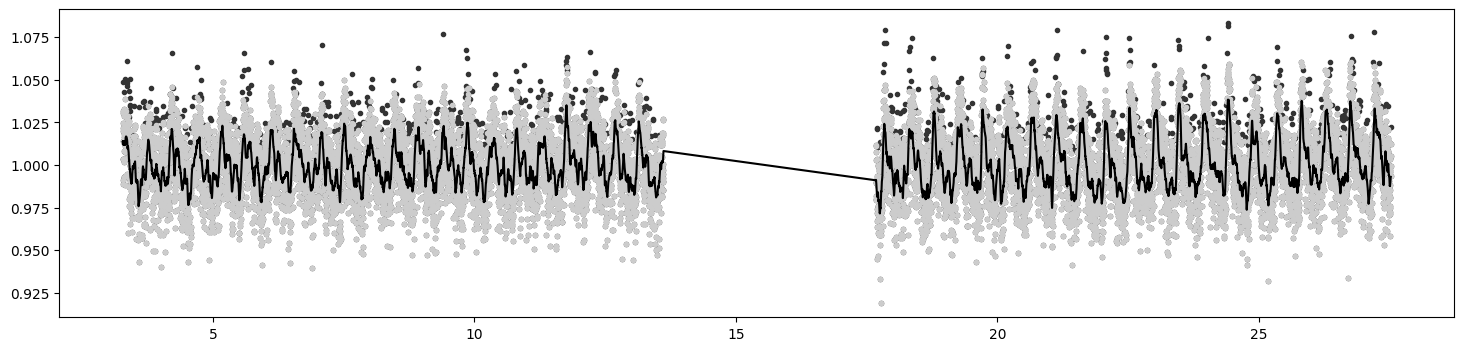

In [173]:
plt.figure(figsize=(18, 4))
plt.plot(data['time'], data['flux'], ".", c="0.2")
plt.plot(data['time'][mask], data['flux'][mask], ".", c="0.8")
plt.plot(data['time'], mu(params), c="k")


In [174]:
gp = build_gp(params, data["time"][mask])
X = np.ones_like(data["time"][mask])[None, :]

nu = Nuance(data["time"][mask], data["flux"][mask], gp=gp, X=X)

In [175]:
from nuance import utils

Ds = np.linspace(0.01, 0.05, 10)
nu.linear_search(data["time"], Ds)

periods = np.linspace(0.3, 5, 10000)
periods = utils.clean_periods(periods, period)
search = nu.periodic_search(periods)


100%|██████████| 9600/9600 [00:17<00:00, 536.63it/s]


In [165]:
period

0.46946586240018867

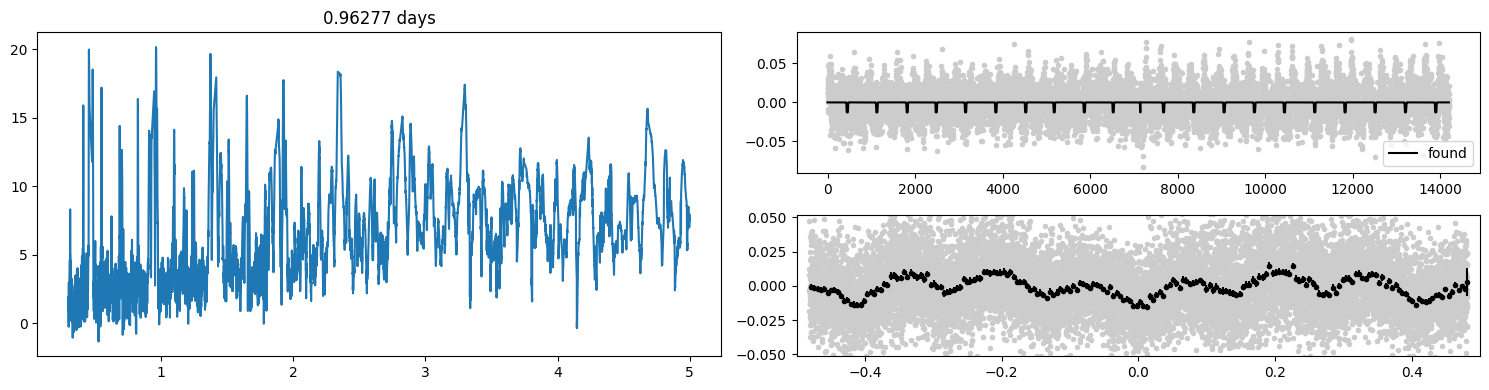

In [167]:
from nuance.utils import plot_search

plt.figure(figsize=(15, 4))
plot_search(nu, search)
plt.tight_layout()

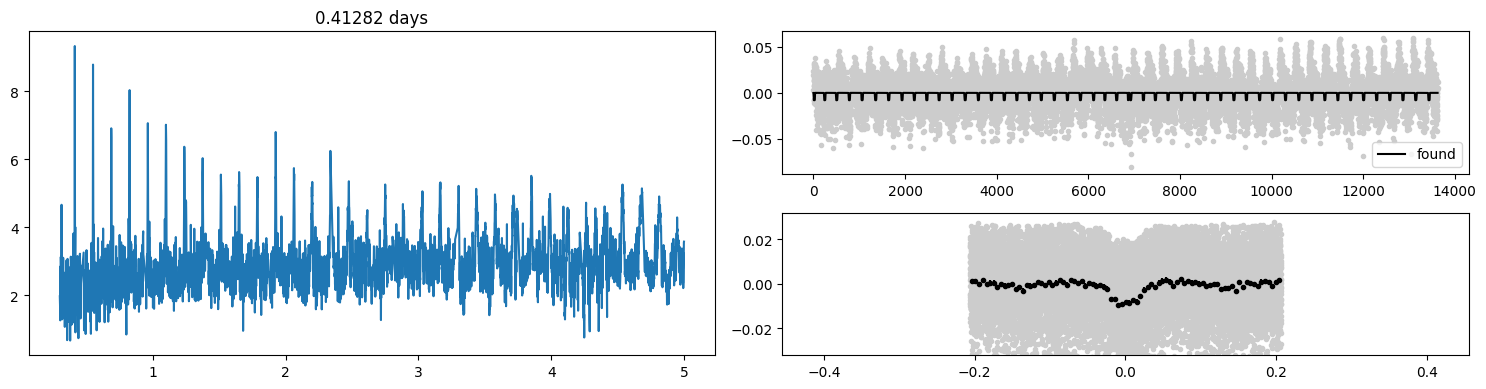

In [128]:
from nuance.utils import plot_search

plt.figure(figsize=(15, 4))
plot_search(nu, search)
plt.tight_layout()

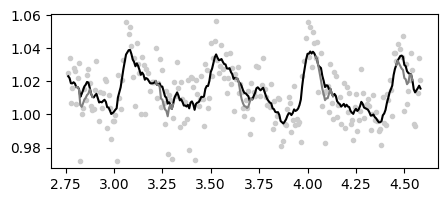

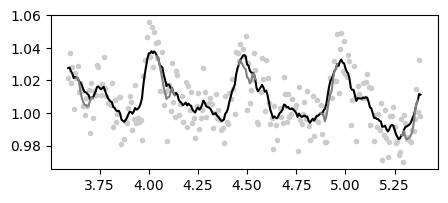

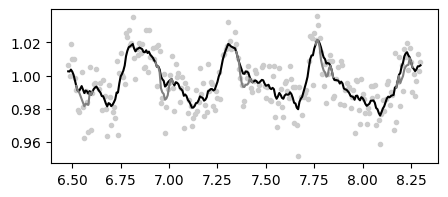

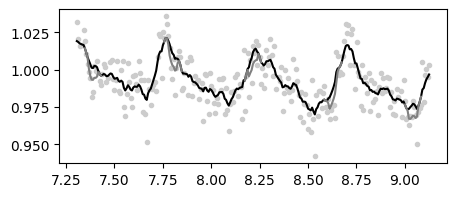

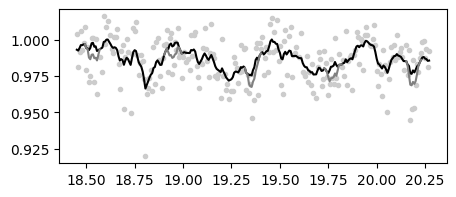

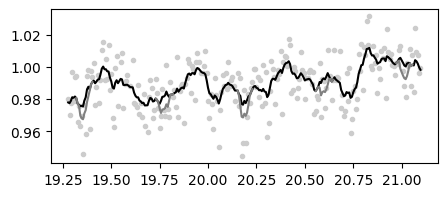

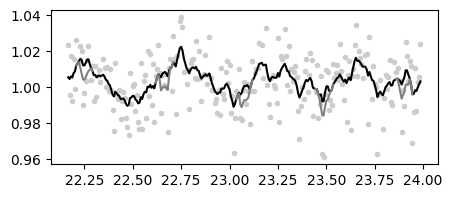

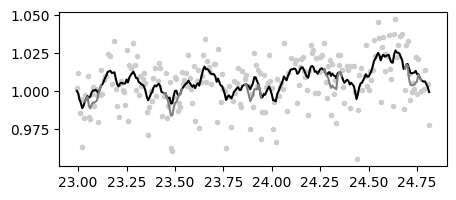

In [158]:
from nuance import utils

t0, D, P = search.best
found_t0s = nu.time[np.flatnonzero(np.abs(utils.phase(nu.time, t0, P)) < 1/24/60)]
linear, astro, noise = nu.models(t0, D, P)

for t in found_t0s:
    mask = np.abs(nu.time - t) < 20*D
    transit_mask = np.abs(utils.phase(nu.time, t, P)) < D
    model_without_transit = np.array(linear + noise)
    # model_without_transit[transit_mask] = np.nan
    model_with_transit = np.array(linear + noise + astro)
    model_with_transit[~transit_mask] = np.nan
    plt.figure(figsize=(5, 2))
    plt.plot(nu.time[mask], nu.flux[mask], ".", c="0.8")
    plt.plot(nu.time[mask], model_without_transit[mask], c="k")
    plt.plot(nu.time[mask], model_with_transit[mask], c="grey")

In [145]:
import pickle

import astropy.units as u
import lightkurve as lk
import numpy as np
import pandas as pd
import yaml

name = f"TIC {tic}"
search_result = lk.search_lightcurve(name)

# data
klc = search_result[9].download()
times = klc.time.to_value("btjd")
fluxes = klc.flux.to_value()
errors = klc.flux_err.to_value()
mask = np.isnan(fluxes) | np.isnan(errors) | np.isnan(times)
original_time = times[~mask]
original_flux = fluxes[~mask]
original_error = errors[~mask]

splits = np.array_split(
    np.arange(len(original_time)), np.flatnonzero(np.diff(original_time) > 0.1) + 1
)

n = 300
time = np.hstack([original_time[split[n:-n]] for split in splits])
flux = np.hstack([original_flux[split[n:-n]] for split in splits])
error = np.hstack([original_error[split[n:-n]] for split in splits])

# first exposure
first_exposure = klc.time[0]
time_format = rf"{first_exposure.format.upper()}_{{{first_exposure.scale.upper()}}}"
first_exposure_time = first_exposure.value

flux_median = np.median(original_flux)
time = time - first_exposure_time
flux /= flux_median
error /= flux_median

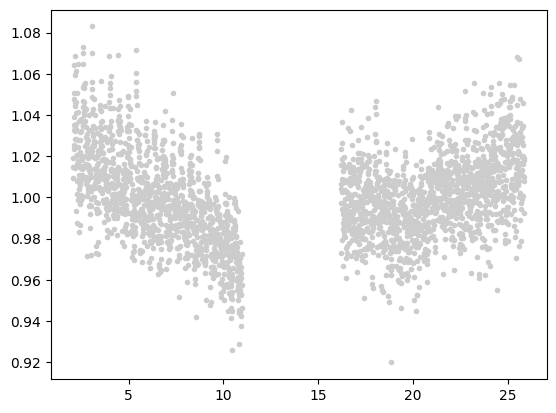

In [146]:
plt.plot(time, flux, ".", c="0.8")

In [147]:
data = dict(
    time=time,
    flux=flux,
    error=error,
)

In [137]:
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,K2 Campaign 111,2016,EVEREST,1800,ktwo237747039,0.0
1,K2 Campaign 111,2016,K2SFF,1800,ktwo237747039,0.0
2,K2 Campaign 112,2016,EVEREST,1800,ktwo237747039,0.0
3,K2 Campaign 112,2016,K2SFF,1800,ktwo237747039,0.0
4,K2 Campaign 11a,2016,K2,1800,ktwo237747039,0.0
5,K2 Campaign 11b,2016,K2,1800,ktwo237747039,0.0
6,TESS Sector 12,2019,SPOC,120,46157102,0.0
7,TESS Sector 12,2019,TESS-SPOC,1800,46157102,0.0
8,TESS Sector 12,2019,QLP,1800,46157102,0.0


In [ ]:
# stellar parameters
url = f"https://exofop.ipac.caltech.edu/tess/download_stellar.php?id={tic}"
star = pd.read_csv(url, delimiter="|", index_col=1).iloc[0]

pickle.dump(
    {
        "flux": flux,
        "time": time,
        "error": error,
    },
    open(snakemake.output.fluxes, "wb"),
)


star_dict = {
    "tic": int(tic),
    "time0": float(first_exposure_time),
    "time0_format": str(time_format),
    "star_period": float(target.LS_Period),
    "star_amplitude": float(target.Amplitude),
    "star_radius": float(star["Radius (R_Sun)"]),
    "star_mass": float(star["Mass (M_Sun)"]),
    "star_teff": float(star["Teff (K)"]),
    "star_logg": float(star["log(g)"]),
    "sector": int(klc.sector),
    "logg": float(star["log(g)"]),
}

ld = pd.read_csv("static/tess_limb_darkening.txt", delim_whitespace=True, comment="#")
closest_teff = ld.Teff.iloc[np.argmin(np.abs(ld.Teff - star_dict["star_teff"]))]
teff_ld = ld[ld.Teff == closest_teff]
ld_row = teff_ld.iloc[np.argmin(np.abs(teff_ld.logg - star_dict["star_logg"]))]
ld_coeffs = ld_row[["aLSM", "bLSM"]].values.astype(float)
float(ld_coeffs[0]), float(ld_coeffs[1])
star_dict["ld_coeffs"] = float(ld_coeffs[0]), float(ld_coeffs[1])

yaml.safe_dump(
    star_dict,
    open(snakemake.output.info, "w"),
)

print(f"Downloaded TIC {tic} data (first sector)")
